In [1]:
from keras.models import Sequential,Model
from keras.layers import Activation
from keras.layers.core import Dense,Flatten,Dropout
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
from sklearn.metrics import confusion_matrix
from keras.optimizers import Adam, RMSprop , SGD
import keras 
import keras.backend as B
import numpy as np
import keras.applications as A
import matplotlib.pyplot as plt
%matplotlib inline

import os
from keras import regularizers

Using TensorFlow backend.


In [2]:
os.listdir("../input/dataset2-master")

['dataset2-master']

In [3]:
cd "../input/dataset2-master/dataset2-master/"

/kaggle/input/dataset2-master/dataset2-master


In [4]:
train_path = "images/TRAIN"
test_path = "images/TEST"

In [5]:
inputs = (240,320,3)

In [6]:
# train_batches = ImageDataGenerator().flow_from_directory(train_path, target_size=(224,224),classes=['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL'],batch_size=50)
# test_batches = ImageDataGenerator().flow_from_directory(test_path, target_size=(224,224),classes=['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL'],batch_size=50)

In [7]:
vgg = A.vgg16.VGG16(weights='imagenet',include_top=False, input_shape=inputs)
#vgg.summary()

Instructions for updating:
Colocations handled automatically by placer.
58892288/58889256 [==============================] - 2s 0us/step


In [8]:
model = Sequential()
for layer in vgg.layers[:-4]:
  layer.trainable=False

In [9]:
for layer in vgg.layers:
  print(layer,layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7ff35b86da20> False
<keras.layers.convolutional.Conv2D object at 0x7ff35bf10470> False
<keras.layers.convolutional.Conv2D object at 0x7ff35b86de10> False
<keras.layers.pooling.MaxPooling2D object at 0x7ff35b0322e8> False
<keras.layers.convolutional.Conv2D object at 0x7ff35b895ef0> False
<keras.layers.convolutional.Conv2D object at 0x7ff35afec160> False
<keras.layers.pooling.MaxPooling2D object at 0x7ff35afff828> False
<keras.layers.convolutional.Conv2D object at 0x7ff35afff390> False
<keras.layers.convolutional.Conv2D object at 0x7ff35afb24e0> False
<keras.layers.convolutional.Conv2D object at 0x7ff35afccb00> False
<keras.layers.pooling.MaxPooling2D object at 0x7ff35af7b278> False
<keras.layers.convolutional.Conv2D object at 0x7ff35afe4e80> False
<keras.layers.convolutional.Conv2D object at 0x7ff35af98da0> False
<keras.layers.convolutional.Conv2D object at 0x7ff35af445f8> False
<keras.layers.pooling.MaxPooling2D object at 0x7ff35af60630>

In [10]:
# Add the vgg convolutional base model
model.add(vgg)
 
# Add new layers
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(32, activation='relu' ))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(16, activation='relu' ))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(8, activation='relu' ))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(4, activation='softmax'))
model.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 10, 512)        14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 35840)             0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 35840)             143360    
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1146912   
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 32)                128       
___________________________

In [11]:
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest', validation_split=0.25)


validation_datagen = ImageDataGenerator(rescale=1./255 )
 
# Change the batchsize according to your system RAM
train_batchsize = 20
val_batchsize = 20

In [12]:
train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=(240, 320),
        batch_size=train_batchsize,
        class_mode='categorical', subset = "training")
 
validation_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=(240, 320),
        batch_size=val_batchsize,
        class_mode='categorical',
        shuffle=False,
    subset='validation')

Found 7470 images belonging to 4 classes.
Found 2487 images belonging to 4 classes.


In [13]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=1e-4),
              metrics=['acc'])

In [14]:
# Train the model
history = model.fit_generator(
      train_generator,
      steps_per_epoch=train_generator.samples//train_generator.batch_size ,
      epochs=50,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples//validation_generator.batch_size,
      verbose=1)

Instructions for updating:
Use tf.cast instead.
Epoch 1/50
373/373 [==============================] - 183s 490ms/step - loss: 1.5988 - acc: 0.3247 - val_loss: 1.3253 - val_acc: 0.4024
Epoch 2/50
373/373 [==============================] - 169s 452ms/step - loss: 1.2735 - acc: 0.4373 - val_loss: 1.2025 - val_acc: 0.4613
Epoch 3/50
373/373 [==============================] - 168s 450ms/step - loss: 1.1117 - acc: 0.5055 - val_loss: 0.7885 - val_acc: 0.7037
Epoch 4/50
373/373 [==============================] - 167s 447ms/step - loss: 0.9781 - acc: 0.5869 - val_loss: 0.7881 - val_acc: 0.7065
Epoch 5/50
373/373 [==============================] - 168s 451ms/step - loss: 0.8688 - acc: 0.6592 - val_loss: 0.5731 - val_acc: 0.8597
Epoch 6/50
373/373 [==============================] - 166s 446ms/step - loss: 0.7742 - acc: 0.7214 - val_loss: 0.6818 - val_acc: 0.7406
Epoch 7/50
373/373 [==============================] - 167s 448ms/step - loss: 0.6800 - acc: 0.7745 - val_loss: 0.7118 - val_acc: 0.7021


In [15]:
model.save("/kaggle/working/model_2.h5")

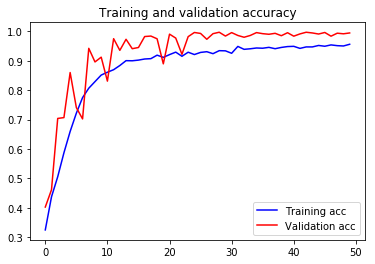

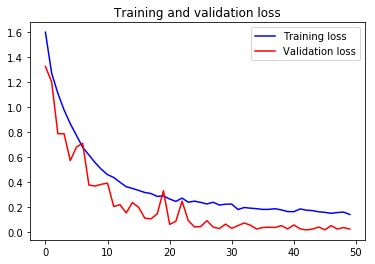

In [16]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [17]:
print("The best Training accuracy {}".format(max(acc)*100))
print("The best validation accuracy {} ".format(max(val_acc)*100))

The best Training accuracy 95.58389191659505
The best validation accuracy 99.67571942005073 
